# Gathering data
### Source 1- File downloade manually

In [2]:
import pandas as pd

In [3]:
d1=pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
d1

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


### Source 2- Udacity Server

In [5]:
import requests
import os

In [6]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

In [7]:
with open(os.path.join('image_predictions.tsv'),mode='wb') as file:
    file.write(r.content)

In [8]:
d2=pd.read_csv('image_predictions.tsv',sep='\t', header=0)

In [9]:
d2

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


### Source 3- Twitter API

In [10]:
import json
d3 = pd.read_json('tweet-json.txt', lines=True)

In [11]:
d3.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


# Assess

In [12]:
d1

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [13]:
d2

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [14]:
d3

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [15]:
len(d3)

2354

In [16]:
len(d1)

2356

In [17]:
len(d2)

2075

In [18]:
d1['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [19]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [20]:
d1['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [21]:
d1[(d1.rating_numerator==1776)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [22]:
d1[d1.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [23]:
d1[d1.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [24]:
d2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [25]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
d3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [27]:
d2['p1'].unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher', 'Bernese_mountain_dog',
       'box_turtle', 'chow', 'shopping_cart', 'miniature_poodle',
       'golden_retriever', 'Gordon_setter', 'Walker_hound', 'pug',
       'bloodhound', 'Lhasa', 'English_setter', 'hen', 'desktop_computer',
       'Italian_greyhound', 'Maltese_dog', 'three-toed_sloth', 'ox',
       'malamute', 'guinea_pig', 'soft-coated_wheaten_terrier',
       'Chihuahua', 'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama', 'Chesapeake_Bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'Ibizan_hound',
       'Border_collie', 'Labrador_retriever', 'seat_belt', 'snail',
       'miniature_schnauzer', 'Airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 'teddy', 

# Quality
### Rating denominator cannot be 0
### Incorrect dog names extracted- eg- rows 2345, 2346 etc in d1
### Retweets need to be removed
### Remove Non Dog tweets
### Null Values in expanded_urls in d1
### COlumn datatypes to be corrected- eg- id_reply_to_user_id
### replace _ with space in dog types
### Capture relevent columns after merging the data
# Tidiness
### 1. Merge d1, d2 and d3
### 2. Merge dog status columns

# Making copies

In [28]:
d11=d1.copy()

In [29]:
d12=d2.copy()

In [30]:
d13=d3.copy()

# Clean
## Quality Issue 1: Rating denominator cannot be 0
### Define
COrrect rating denominator to 10 where it is 0
### Code

In [31]:
d1['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [32]:
d1=d1[(d1.rating_denominator!=0)]

### Test

In [33]:
d1['rating_denominator'].unique()

array([ 10,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40, 130,
       110,  16, 120,   2])

## Quality Issue 2: Incorrect dog names extracted- eg- rows 2345, 2346 etc in d1
### Define
Remove dog names where incorrect
### Code

In [34]:
d1[(d1.name=='a')|(d1.name=='an')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
759,778396591732486144,NaN,NaN,2016-09-21 00:53:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is an East African Chalupa...,7.030419e+17,4.196984e+09,2016-02-26 02:20:37 +0000,https://twitter.com/dog_rates/status/703041949...,10,10,an,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1025,746369468511756288,NaN,NaN,2016-06-24 15:48:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Iraqi Speed Kangaroo. It is not a d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746369468...,9,10,an,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None


In [35]:
d1 = d1.replace(['a'],'no name')

In [36]:
d1= d1.replace(['an'],'no name')

### Test

In [37]:
d1[(d1.name=='a')|(d1.name=='an')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Quality Issue 3: Retweets need to be removed
### Define
Remove rows which are retweets
### Code

In [38]:
d1 = d1[d1['retweeted_status_timestamp'].isna()]

### Test

In [39]:
len(d1)

2174

In [40]:
d1[(d1.retweeted_status_timestamp.notnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Quality Issue 4: Remove non dog tweets
### Define
Extract and remove rows which are not for dogs - all p1, p2 and p3 return false
### Code

In [41]:
d2=d2[(d2.p1_dog==True)| (d2.p2_dog==True)|(d2.p3_dog==True)]

### Test

In [42]:
len(d2)

1751

In [43]:
d2[(d2.p1_dog==False)&(d2.p2_dog==False)&(d2.p3_dog==False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


## Quality Issue 5: Null Values in expanded_urls in d1
### Define
Removee rows with null values
### Code

In [44]:
d1=d1[(d1.expanded_urls.notnull())]

### Test

In [45]:
len(d1)

2117

In [46]:
d1[(d1.expanded_urls.isnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Tidiness Issue 2: Merge dog stages in 1 single column
### Define
Make a new column and store the value which is not null from the dog stages
### Code

In [47]:
d1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [48]:
d1.doggo.replace('None', '', inplace=True)

In [49]:
d1.pupper.replace('None','',inplace=True)

In [50]:
d1.floofer.replace('None','',inplace=True)

In [51]:
d1.puppo.replace('None','',inplace=True)

In [52]:
d1['stage']=d1.doggo+d1.floofer+d1.puppo+d1.pupper

In [53]:
d1['stage'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

In [54]:
d1.stage.replace('','None',inplace=True)

In [55]:
d1.stage.replace('doggopupper','doggo+pupper',inplace=True)

In [56]:
d1.stage.replace('doggofloofer','doggo+floofer',inplace=True)

In [57]:
d1.stage.replace('doggopuppo','doggo+puppo',inplace=True)

### Test

In [58]:
d1['stage'].unique()

array(['None', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo+puppo',
       'doggo+floofer', 'doggo+pupper'], dtype=object)

## Quality Issue 7: '_' in dog types in p1, p2 and p3
### Define
Replace _ with space in dog types in p1,p2 and p3
### Code

In [59]:
d2['p1'] = d2['p1'].str.replace('_',' ')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
d2['p2'] = d2['p2'].str.replace('_',' ')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
d2['p3'] = d2['p3'].str.replace('_',' ')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Test

In [62]:
d2

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese mountain dog,0.651137,True,English springer,0.263788,True,Greater Swiss Mountain dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan mastiff,0.058279,True,fur coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping cart,0.962465,False,shopping basket,0.014594,False,golden retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature poodle,0.201493,True,komondor,0.192305,True,soft-coated wheaten terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden retriever,0.775930,True,Tibetan mastiff,0.093718,True,Labrador retriever,0.072427,True


## Tidiness issue 1 - Merge d1, d2 and d3
### Define
Create a new dataframe, and merge d1,d2 and d3
### Code

In [63]:
d_merged=pd.merge(d1,d2)

In [64]:
d3.rename(columns = {'id':'tweet_id'}, inplace = True)
d_fin=pd.merge(d_merged,d3)

### Test

In [65]:
len(d_fin)

1686

In [66]:
d_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 1685
Data columns (total 56 columns):
tweet_id                         1686 non-null int64
in_reply_to_status_id            20 non-null float64
in_reply_to_user_id              20 non-null float64
timestamp                        1686 non-null object
source                           1686 non-null object
text                             1686 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1686 non-null object
rating_numerator                 1686 non-null int64
rating_denominator               1686 non-null int64
name                             1686 non-null object
doggo                            1686 non-null object
floofer                          1686 non-null object
pupper                           1686 non-null object
puppo                            1686 non

In [67]:
d_fin.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,possibly_sensitive,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,truncated,user
0,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.0,0.0,NaN,NaN,NaN,6514,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.0,0.0,NaN,NaN,NaN,4328,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.0,0.0,NaN,NaN,NaN,8964,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.0,0.0,NaN,NaN,NaN,9774,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,0.0,0.0,NaN,NaN,NaN,3261,False,NaN,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


## Quality issue 6:COlumn datatypes to be corrected- eg- id_reply_to_user_id
### Define
Modify datatype from float to object
### Code

In [68]:
d_fin=d_fin.astype({"in_reply_to_user_id":object})

### Test

In [69]:
d_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 1685
Data columns (total 56 columns):
tweet_id                         1686 non-null int64
in_reply_to_status_id            20 non-null float64
in_reply_to_user_id              20 non-null object
timestamp                        1686 non-null object
source                           1686 non-null object
text                             1686 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1686 non-null object
rating_numerator                 1686 non-null int64
rating_denominator               1686 non-null int64
name                             1686 non-null object
doggo                            1686 non-null object
floofer                          1686 non-null object
pupper                           1686 non-null object
puppo                            1686 non-

## Quality Issue 8: Capture relevent columns for the three tables
### Define
Remove additional columns from the dataset
### Code

In [70]:
d_fin.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 1685
Data columns (total 56 columns):
tweet_id                         1686 non-null int64
in_reply_to_status_id            20 non-null float64
in_reply_to_user_id              20 non-null object
timestamp                        1686 non-null object
source                           1686 non-null object
text                             1686 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1686 non-null object
rating_numerator                 1686 non-null int64
rating_denominator               1686 non-null int64
name                             1686 non-null object
doggo                            1686 non-null object
floofer                          1686 non-null object
pupper                           1686 non-null object
puppo                            1686 non-

In [71]:
d_fin2=d_fin[['tweet_id','user','retweet_count','place','favorite_count','created_at','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog','jpg_url','name','stage','timestamp','source','text','rating_numerator','rating_denominator','expanded_urls']]

### Test

In [72]:
d_fin2.head()

,tweet_id,user,retweet_count,place,favorite_count,created_at,p1,p1_conf,p1_dog,p2,...,p3_dog,jpg_url,name,stage,timestamp,source,text,rating_numerator,rating_denominator,expanded_urls
0,892177421306343426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",6514,None,33819,2017-08-01 00:17:27,Chihuahua,0.323581,True,Pekinese,...,True,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tilly,None,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,https://twitter.com/dog_rates/status/892177421...
1,891815181378084864,"{'id': 4196983835, 'id_str': '4196983835', 'na...",4328,None,25461,2017-07-31 00:18:03,Chihuahua,0.716012,True,malamute,...,True,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Archie,None,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,https://twitter.com/dog_rates/status/891815181...
2,891689557279858688,"{'id': 4196983835, 'id_str': '4196983835', 'na...",8964,None,42908,2017-07-30 15:58:51,paper towel,0.170278,False,Labrador retriever,...,False,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Darla,None,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,https://twitter.com/dog_rates/status/891689557...
3,891327558926688256,"{'id': 4196983835, 'id_str': '4196983835', 'na...",9774,None,41048,2017-07-29 16:00:24,basset,0.555712,True,English springer,...,True,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Franklin,None,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,https://twitter.com/dog_rates/status/891327558...
4,891087950875897856,"{'id': 4196983835, 'id_str': '4196983835', 'na...",3261,None,20562,2017-07-29 00:08:17,Chesapeake Bay retriever,0.425595,True,Irish terrier,...,False,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,None,None,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13,10,https://twitter.com/dog_rates/status/891087950...


# Storing in a CSV file

In [73]:
d_fin2.to_csv('twitter_Archive_master.csv')

# Visualization

In [74]:
d_fin2.head()

,tweet_id,user,retweet_count,place,favorite_count,created_at,p1,p1_conf,p1_dog,p2,...,p3_dog,jpg_url,name,stage,timestamp,source,text,rating_numerator,rating_denominator,expanded_urls
0,892177421306343426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",6514,None,33819,2017-08-01 00:17:27,Chihuahua,0.323581,True,Pekinese,...,True,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tilly,None,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,https://twitter.com/dog_rates/status/892177421...
1,891815181378084864,"{'id': 4196983835, 'id_str': '4196983835', 'na...",4328,None,25461,2017-07-31 00:18:03,Chihuahua,0.716012,True,malamute,...,True,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Archie,None,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,https://twitter.com/dog_rates/status/891815181...
2,891689557279858688,"{'id': 4196983835, 'id_str': '4196983835', 'na...",8964,None,42908,2017-07-30 15:58:51,paper towel,0.170278,False,Labrador retriever,...,False,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Darla,None,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,https://twitter.com/dog_rates/status/891689557...
3,891327558926688256,"{'id': 4196983835, 'id_str': '4196983835', 'na...",9774,None,41048,2017-07-29 16:00:24,basset,0.555712,True,English springer,...,True,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Franklin,None,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,https://twitter.com/dog_rates/status/891327558...
4,891087950875897856,"{'id': 4196983835, 'id_str': '4196983835', 'na...",3261,None,20562,2017-07-29 00:08:17,Chesapeake Bay retriever,0.425595,True,Irish terrier,...,False,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,None,None,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13,10,https://twitter.com/dog_rates/status/891087950...


In [75]:
d_fin2['rating_decimal']=d_fin2['rating_numerator']/d_fin2['rating_denominator']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
d_fin2

,tweet_id,user,retweet_count,place,favorite_count,created_at,p1,p1_conf,p1_dog,p2,...,jpg_url,name,stage,timestamp,source,text,rating_numerator,rating_denominator,expanded_urls,rating_decimal
0,892177421306343426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",6514,None,33819,2017-08-01 00:17:27,Chihuahua,0.323581,True,Pekinese,...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tilly,None,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,https://twitter.com/dog_rates/status/892177421...,1.3
1,891815181378084864,"{'id': 4196983835, 'id_str': '4196983835', 'na...",4328,None,25461,2017-07-31 00:18:03,Chihuahua,0.716012,True,malamute,...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Archie,None,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,https://twitter.com/dog_rates/status/891815181...,1.2
2,891689557279858688,"{'id': 4196983835, 'id_str': '4196983835', 'na...",8964,None,42908,2017-07-30 15:58:51,paper towel,0.170278,False,Labrador retriever,...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Darla,None,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,https://twitter.com/dog_rates/status/891689557...,1.3
3,891327558926688256,"{'id': 4196983835, 'id_str': '4196983835', 'na...",9774,None,41048,2017-07-29 16:00:24,basset,0.555712,True,English springer,...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Franklin,None,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,https://twitter.com/dog_rates/status/891327558...,1.2
4,891087950875897856,"{'id': 4196983835, 'id_str': '4196983835', 'na...",3261,None,20562,2017-07-29 00:08:17,Chesapeake Bay retriever,0.425595,True,Irish terrier,...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,None,None,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13,10,https://twitter.com/dog_rates/status/891087950...,1.3
5,890971913173991426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2158,None,12041,2017-07-28 16:27:12,Appenzeller,0.341703,True,Border collie,...,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Jax,None,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,13,10,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",1.3
6,890729181411237888,"{'id': 4196983835, 'id_str': '4196983835', 'na...",16716,None,56848,2017-07-28 00:22:40,Pomeranian,0.566142,True,Eskimo dog,...,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,None,None,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,13,10,https://twitter.com/dog_rates/status/890729181...,1.3
7,890609185150312448,"{'id': 4196983835, 'id_str': '4196983835', 'na...",4429,None,28226,2017-07-27 16:25:51,Irish terrier,0.487574,True,Irish setter,...,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Zoey,None,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,13,10,https://twitter.com/dog_rates/status/890609185...,1.3
8,890240255349198849,"{'id': 4196983835, 'id_str': '4196983835', 'na...",7711,None,32467,2017-07-26 15:59:51,Pembroke,0.511319,True,Cardigan,...,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Cassie,doggo,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,https://twitter.com/dog_rates/status/890240255...,1.4
9,890006608113172480,"{'id': 4196983835, 'id_str': '4196983835', 'na...",7624,None,31166,2017-07-26 00:31:25,Samoyed,0.957979,True,Pomeranian,...,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,

In [77]:
d_fin2.loc[d_fin2['rating_decimal'].idxmax()]

tweet_id                                             786709082849828864
user                  {'id': 4196983835, 'id_str': '4196983835', 'na...
retweet_count                                                      7069
place                                                              None
favorite_count                                                    20296
created_at                                          2016-10-13 23:23:56
p1                                                           Pomeranian
p1_conf                                                        0.467321
p1_dog                                                             True
p2                                                          Persian cat
p2_conf                                                        0.122978
p2_dog                                                            False
p3                                                                 chow
p3_conf                                                        0

In [82]:
d_fin2.head()

,tweet_id,user,retweet_count,place,favorite_count,created_at,p1,p1_conf,p1_dog,p2,...,jpg_url,name,stage,timestamp,source,text,rating_numerator,rating_denominator,expanded_urls,rating_decimal
0,892177421306343426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",6514,None,33819,2017-08-01 00:17:27,Chihuahua,0.323581,True,Pekinese,...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tilly,None,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,https://twitter.com/dog_rates/status/892177421...,1.3
1,891815181378084864,"{'id': 4196983835, 'id_str': '4196983835', 'na...",4328,None,25461,2017-07-31 00:18:03,Chihuahua,0.716012,True,malamute,...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Archie,None,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,https://twitter.com/dog_rates/status/891815181...,1.2
2,891689557279858688,"{'id': 4196983835, 'id_str': '4196983835', 'na...",8964,None,42908,2017-07-30 15:58:51,paper towel,0.170278,False,Labrador retriever,...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Darla,None,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,https://twitter.com/dog_rates/status/891689557...,1.3
3,891327558926688256,"{'id': 4196983835, 'id_str': '4196983835', 'na...",9774,None,41048,2017-07-29 16:00:24,basset,0.555712,True,English springer,...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Franklin,None,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,https://twitter.com/dog_rates/status/891327558...,1.2
4,891087950875897856,"{'id': 4196983835, 'id_str': '4196983835', 'na...",3261,None,20562,2017-07-29 00:08:17,Chesapeake Bay retriever,0.425595,True,Irish terrier,...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,None,None,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13,10,https://twitter.com/dog_rates/status/891087950...,1.3


In [84]:
d_fin2.loc[d_fin2['favorite_count'].idxmax()]

tweet_id                                             822872901745569793
user                  {'id': 4196983835, 'id_str': '4196983835', 'na...
retweet_count                                                     48265
place                                                              None
favorite_count                                                   132810
created_at                                          2017-01-21 18:26:02
p1                                                     Lakeland terrier
p1_conf                                                        0.196015
p1_dog                                                             True
p2                                                   Labrador retriever
p2_conf                                                        0.160329
p2_dog                                                             True
p3                                                        Irish terrier
p3_conf                                                       0.

In [89]:
d_fin2.sort_values(by='favorite_count', ascending=False)[['favorite_count','p1_conf','p1','p2_conf','p2','p3_conf','p3']]

,favorite_count,p1_conf,p1,p2_conf,p2,p3_conf,p3
278,132810,0.196015,Lakeland terrier,0.160329,Labrador retriever,0.069126,Irish terrier
691,131075,0.825333,Labrador retriever,0.044681,ice bear,0.018442,whippet
53,107956,0.383404,English springer,0.134967,Boston bull,0.110481,Cardigan
363,107015,0.505370,Chihuahua,0.120358,Pomeranian,0.077008,toy terrier
100,106827,0.905334,French bulldog,0.078060,Boston bull,0.001771,pug
299,95450,0.351308,standard poodle,0.271929,toy poodle,0.094759,Tibetan terrier
86,85011,0.841001,golden retriever,0.099278,Great Pyrenees,0.032621,Labrador retriever
365,75639,0.366248,Arabian camel,0.209852,house finch,0.046403,cocker spaniel
122,75193,0.224218,Angora,0.216163,malamute,0.128383,Persian cat
719,75163,0.503372,Eskimo dog,0.390413,Siberian husky,0.080901,malamute


In [91]:
d_fin2.loc[d_fin2['p3_conf'].idxmax()]

tweet_id                                             716439118184652801
user                  {'id': 4196983835, 'id_str': '4196983835', 'na...
retweet_count                                                       247
place                                                              None
favorite_count                                                     2574
created_at                                          2016-04-03 01:36:11
p1                                                       Siberian husky
p1_conf                                                        0.396495
p1_dog                                                             True
p2                                                             malamute
p2_conf                                                        0.317053
p2_dog                                                             True
p3                                                           Eskimo dog
p3_conf                                                        0

In [92]:
item_counts = d_fin2["p1"].value_counts(normalize=True)

In [93]:
item_counts

golden retriever               0.082444
Labrador retriever             0.056346
Pembroke                       0.052195
Chihuahua                      0.046856
pug                            0.032028
chow                           0.024318
Samoyed                        0.023725
Pomeranian                     0.022539
toy poodle                     0.022539
malamute                       0.017200
cocker spaniel                 0.016014
French bulldog                 0.015421
Chesapeake Bay retriever       0.013642
miniature pinscher             0.013049
German shepherd                0.011862
Siberian husky                 0.011862
seat belt                      0.011862
Staffordshire bullterrier      0.011269
Shetland sheepdog              0.010676
Maltese dog                    0.010676
Eskimo dog                     0.010676
Shih-Tzu                       0.010083
beagle                         0.010083
Cardigan                       0.010083
Rottweiler                     0.010083


In [94]:
item_counts1 = d_fin2["p2"].value_counts(normalize=True)

In [95]:
item_counts1

Labrador retriever                0.056940
golden retriever                  0.048636
Cardigan                          0.042705
Chihuahua                         0.025504
Chesapeake Bay retriever          0.023725
Pomeranian                        0.023132
French bulldog                    0.023132
toy poodle                        0.021352
Siberian husky                    0.019573
cocker spaniel                    0.018980
miniature poodle                  0.018980
beagle                            0.016607
Eskimo dog                        0.016014
collie                            0.015421
Pembroke                          0.014828
kuvasz                            0.014235
Italian greyhound                 0.013049
Pekinese                          0.012456
chow                              0.011862
malinois                          0.011862
miniature pinscher                0.011862
American Staffordshire terrier    0.011862
toy terrier                       0.011269
Norwegian e

In [96]:
item_counts2 = d_fin2["p3"].value_counts(normalize=True)

In [97]:
item_counts2

Labrador retriever                0.045077
Chihuahua                         0.033808
golden retriever                  0.027284
Eskimo dog                        0.021352
kelpie                            0.019573
kuvasz                            0.018387
chow                              0.018387
beagle                            0.017794
Staffordshire bullterrier         0.017794
cocker spaniel                    0.017200
toy poodle                        0.017200
Pekinese                          0.016607
Pomeranian                        0.016014
Pembroke                          0.015421
Great Pyrenees                    0.015421
French bulldog                    0.014828
malamute                          0.014828
Chesapeake Bay retriever          0.014235
American Staffordshire terrier    0.013642
Cardigan                          0.013642
pug                               0.012456
basenji                           0.011862
bull mastiff                      0.011269
Siberian hu

In [99]:
d_fin2.head()

,tweet_id,user,retweet_count,place,favorite_count,created_at,p1,p1_conf,p1_dog,p2,...,jpg_url,name,stage,timestamp,source,text,rating_numerator,rating_denominator,expanded_urls,rating_decimal
0,892177421306343426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",6514,None,33819,2017-08-01 00:17:27,Chihuahua,0.323581,True,Pekinese,...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tilly,None,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,https://twitter.com/dog_rates/status/892177421...,1.3
1,891815181378084864,"{'id': 4196983835, 'id_str': '4196983835', 'na...",4328,None,25461,2017-07-31 00:18:03,Chihuahua,0.716012,True,malamute,...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Archie,None,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,https://twitter.com/dog_rates/status/891815181...,1.2
2,891689557279858688,"{'id': 4196983835, 'id_str': '4196983835', 'na...",8964,None,42908,2017-07-30 15:58:51,paper towel,0.170278,False,Labrador retriever,...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Darla,None,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,https://twitter.com/dog_rates/status/891689557...,1.3
3,891327558926688256,"{'id': 4196983835, 'id_str': '4196983835', 'na...",9774,None,41048,2017-07-29 16:00:24,basset,0.555712,True,English springer,...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Franklin,None,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,https://twitter.com/dog_rates/status/891327558...,1.2
4,891087950875897856,"{'id': 4196983835, 'id_str': '4196983835', 'na...",3261,None,20562,2017-07-29 00:08:17,Chesapeake Bay retriever,0.425595,True,Irish terrier,...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,None,None,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,13,10,https://twitter.com/dog_rates/status/891087950...,1.3


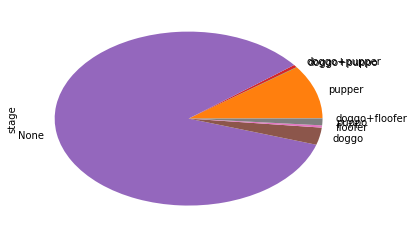

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
d_fin2.stage.value_counts(sort=False).plot.pie()
plt.show()